In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# Constants
target = 'popularity'
seed = 24
n_estimators = 100

In [4]:
# Load the datasets
spotify_songs = pd.read_csv('data/spotify_songs.csv')
taylorswift_features = pd.read_csv('data/taylorswift-Features.csv', index_col=0)
taylorswift_tracks = pd.read_csv('data/taylorswift-Tracks.csv', index_col=0)

## Fixing Columns and Merging the Data

In [5]:
# Convert duration to numerical format
taylorswift_tracks['duration'] = pd.to_timedelta(taylorswift_tracks['duration']).dt.total_seconds() * 1000

# Convert track_album_release_date to datetime format
taylorswift_tracks['release_date'] = pd.to_datetime(taylorswift_tracks['release_date'], errors='coerce')
taylorswift_tracks['explicit'] = taylorswift_tracks['explicit'].astype(int)

In [6]:
# Merge the Taylor Swift Tracks and Features datasets
merged_data = pd.merge(taylorswift_tracks, taylorswift_features, left_on='id', right_on='id')

# Reorder the columns to place 'popularity' at the end
cols = merged_data.columns.tolist()
cols.append(cols.pop(cols.index(target)))
merged_data = merged_data[cols]

## Describing Datasets

In [7]:
print("\nTaylor Swift Merged Dataset:")
merged_data.head()


Taylor Swift Merged Dataset:


,album_id_x,album_name_x,id,name,release_date,duration,track_number,explicit,uri,album_id_y,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
0,1o59UpKw81iHR0HPiSkJR0,1989 (Taylor's Version) [Deluxe],4WUepByoeqcedHoYhSNHRt,Welcome To New York (Taylor's Version),2023-10-27,212000.0,1,0,spotify:track:4WUepByoeqcedHoYhSNHRt,1o59UpKw81iHR0HPiSkJR0,...,7,-4.840,1,0.0327,0.009420,0.000037,0.3670,0.685,116.998,71
1,1o59UpKw81iHR0HPiSkJR0,1989 (Taylor's Version) [Deluxe],0108kcWLnn2HlH2kedi1gn,Blank Space (Taylor's Version),2023-10-27,231000.0,2,0,spotify:track:0108kcWLnn2HlH2kedi1gn,1o59UpKw81iHR0HPiSkJR0,...,0,-5.376,1,0.0670,0.088500,0.000000,0.1680,0.701,96.057,72
2,1o59UpKw81iHR0HPiSkJR0,1989 (Taylor's Version) [Deluxe],3Vpk1hfMAQme8VJ0SNRSkd,Style (Taylor's Version),2023-10-27,231000.0,3,0,spotify:track:3Vpk1hfMAQme8VJ0SNRSkd,1o59UpKw81iHR0HPiSkJR0,...,11,-4.785,0,0.0397,0.000421,0.019700,0.0899,0.305,94.868,73
3,1o59UpKw81iHR0HPiSkJR0,1989 (Taylor's Version) [Deluxe],1OcSfkeCg9hRC2sFKB4IMJ,Out Of The Woods (Taylor's Version),2023-10-27,235000.0,4,0,spotify:track:1OcSfkeCg9hRC2sFKB4IMJ,1o59UpKw81iHR0HPiSkJR0,...,0,-5.968,1,0.0447,0.000537,0.000056,0.3850,0.206,92.021,72
4,1o59UpKw81iHR0HPiSkJR0,1989 (Taylor's Version) [Deluxe],2k0ZEeAqzvYMcx9Qt5aClQ,All You Had To Do Was Stay (Taylor's Version),2023-10-27,193000.0,5,0,spotify:track:2k0ZEeAqzvYMcx9Qt5aClQ,1o59UpKw81iHR0HPiSkJR0,...,0,-5.579,1,0.0317,0.000656,0.000000,0.1310,0.520,96.997,70


In [8]:
print("\nTaylor Swift Merged Info:")
merged_data.info()


Taylor Swift Merged Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   album_id_x        246 non-null    object        
 1   album_name_x      246 non-null    object        
 2   id                246 non-null    object        
 3   name              246 non-null    object        
 4   release_date      246 non-null    datetime64[ns]
 5   duration          246 non-null    float64       
 6   track_number      246 non-null    int64         
 7   explicit          246 non-null    int32         
 8   uri               246 non-null    object        
 9   album_id_y        246 non-null    object        
 10  album_name_y      246 non-null    object        
 11  track_name        246 non-null    object        
 12  danceability      246 non-null    float64       
 13  energy            246 non-null    float64       
 14 

In [9]:
merged_data.describe()

,release_date,duration,track_number,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
count,246,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,2019-03-17 11:36:35.121951232,238304.878049,9.382114,0.093496,0.571496,0.573577,4.560976,-7.535431,0.902439,0.054661,0.327883,0.003181,0.177638,0.392932,125.163744,66.743902
min,2006-10-24 00:00:00,83000.000000,1.000000,0.000000,0.243000,0.131000,0.000000,-15.489000,0.000000,0.023100,0.000184,0.000000,0.035700,0.038200,68.534000,34.000000
25%,2017-11-10 00:00:00,209250.000000,5.000000,0.000000,0.496000,0.436500,2.000000,-9.320750,1.000000,0.030825,0.025800,0.000000,0.093100,0.249750,99.206750,59.000000
50%,2020-11-25 00:00:00,232500.000000,9.000000,0.000000,0.581500,0.584500,5.000000,-7.012000,1.000000,0.038450,0.156500,0.000001,0.116500,0.385500,120.527000,70.000000
75%,2021-11-12 00:00:00,257750.000000,14.000000,0.000000,0.651000,0.720500,7.000000,-5.373750,1.000000,0.057325,0.670000,0.000030,0.162250,0.519500,147.980250,75.000000
max,2023-10-27 00:00:00,405000.000000,20.000000,1.000000,0.897000,0.949000,11.000000,-1.909000,1.000000,0.519000,0.971000,0.328000,0.931000,0.920000,208.918000,99.000000
std,NaN,45720.005631,5.430106,0.291720,0.123010,0.191058,3.337227,2.870830,0.297325,0.051035,0.335263,0.026029,0.177817,0.187662,31.796187,13.769363


## Data Display

In [10]:
# Identify non-numerical columns
non_numerical_columns = merged_data.select_dtypes(include=['object', 'bool']).columns

# Drop non-numerical columns
numerical_data = merged_data.drop(columns=non_numerical_columns)

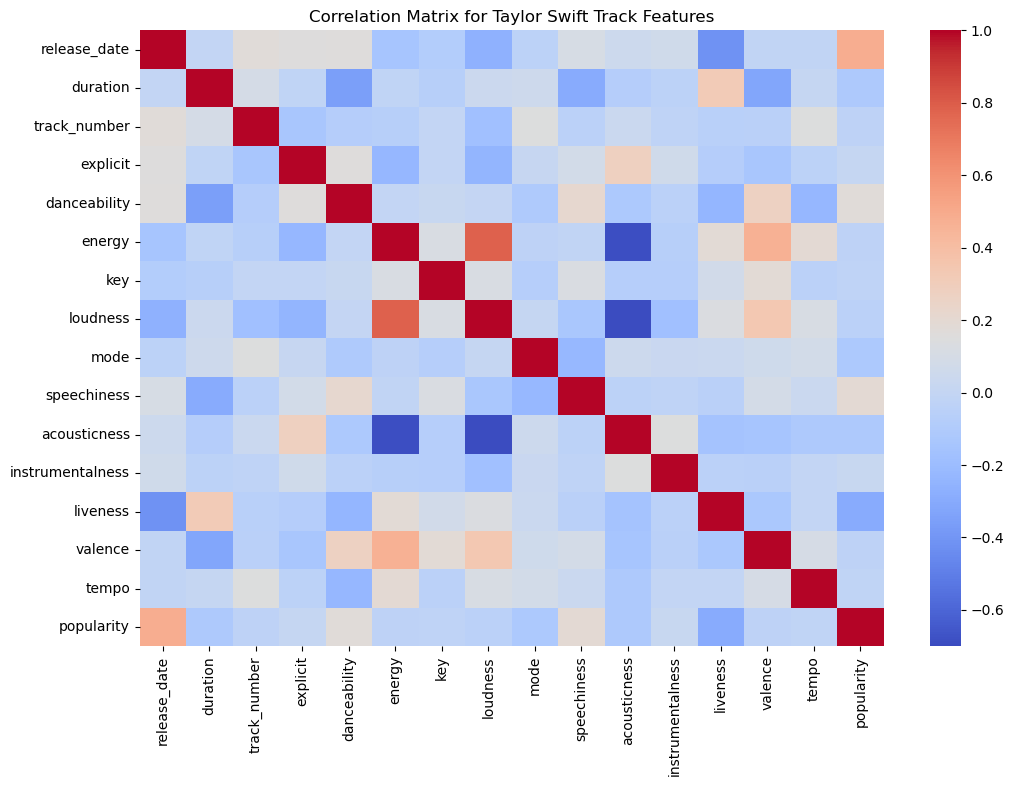

In [11]:
# Compute correlation matrix
correlation_matrix = numerical_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')

plt.title('Correlation Matrix for Taylor Swift Track Features')
plt.show()

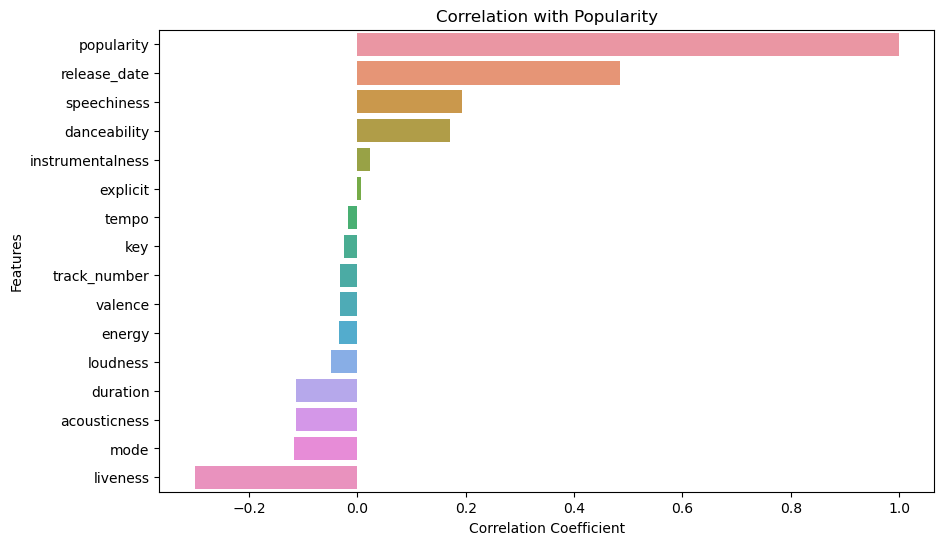

In [12]:
# Extract the correlation with the target column 'popularity'
correlation_with_popularity = correlation_matrix['popularity'].sort_values(ascending=False)

# Visualize the correlation with 'popularity'
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_popularity.values, y=correlation_with_popularity.index)
plt.title('Correlation with Popularity')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

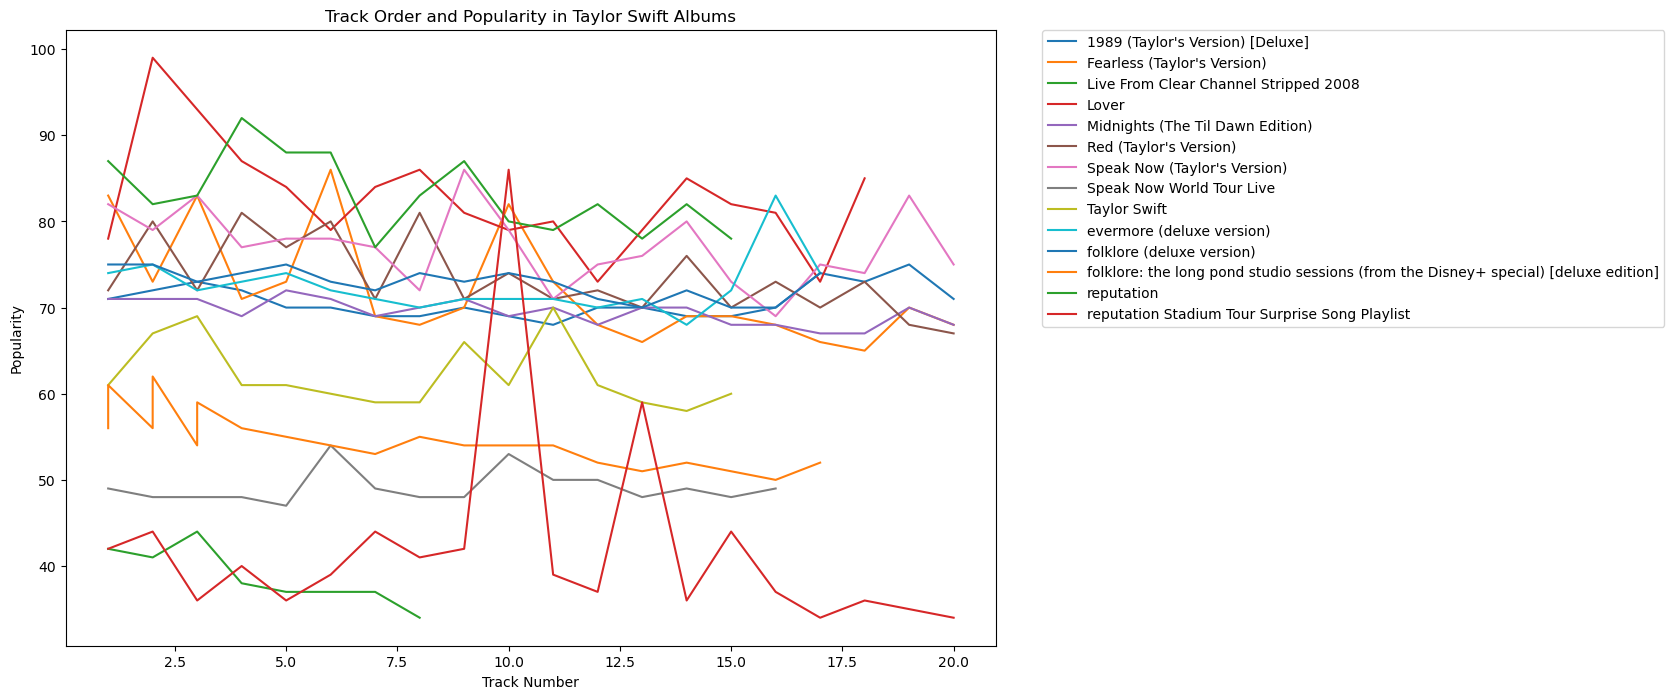

In [13]:
# Extract relevant columns for analysis
track_order = taylorswift_tracks[['track_number', 'album_name', 'popularity']]

# Sort by album name and track number
track_order = track_order.sort_values(by=['album_name', 'track_number'])

# Visualize the track order and their popularity
plt.figure(figsize=(12, 8))
for album in track_order['album_name'].unique():
    album_data = track_order[track_order['album_name'] == album]
    plt.plot(album_data['track_number'], album_data['popularity'], label=album)

plt.xlabel('Track Number')
plt.ylabel('Popularity')
plt.title('Track Order and Popularity in Taylor Swift Albums')

# Adjust legend to be outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

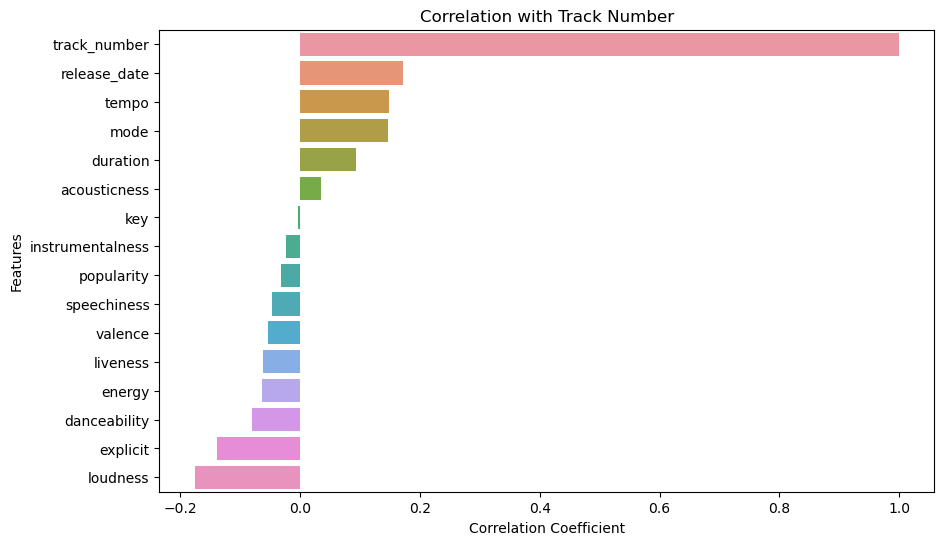

In [14]:
# Extract the correlation with the track number
correlation_with_track_number = correlation_matrix['track_number'].sort_values(ascending=False)

# Visualize the correlation with track number
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_track_number.values, y=correlation_with_track_number.index)
plt.title('Correlation with Track Number')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

## Preprocessing

In [15]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

In [16]:
def preprocessData(df, target):
    processed_data = df.copy()
    processed_data['season'] = processed_data['release_date'].dt.month.apply(month_to_season)
    season_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
    processed_data['season'] = processed_data['season'].map(season_mapping)

    processed_data['month'] = processed_data['release_date'].dt.month
    processed_data['weekday'] = processed_data['release_date'].dt.dayofweek
    processed_data['year'] = processed_data['release_date'].dt.year

    # Find the last release date of each album
    album_release_dates = processed_data.groupby('album_name_x')['release_date'].min().reset_index()
    album_release_dates.columns = ['album_name_x', 'first_release_date']

    # Merge this information back into the original DataFrame
    processed_data = processed_data.merge(album_release_dates, on='album_name_x', how='left')

    # Sort by album release date
    album_release_dates = album_release_dates.sort_values(by='first_release_date').reset_index(drop=True)

    # Calculate the days since the last album release
    album_release_dates['days_since_last_album'] = album_release_dates['first_release_date'].diff().dt.days
    album_release_dates['days_since_last_album'] = album_release_dates['days_since_last_album'].fillna(0)

    # Merge this information back into the original DataFrame
    processed_data = processed_data.merge(album_release_dates[['album_name_x', 'days_since_last_album']], on='album_name_x', how='left')

    # Calculate the number of tracks in each album
    album_track_counts = processed_data['album_name_x'].value_counts().to_dict()

    # Add the number of tracks in the same album as a new feature
    processed_data['tracks_in_album'] = processed_data['album_name_x'].map(album_track_counts)

    
    # Features to fit Polynomial Features
    poly_feature_columns = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    # Instantiate the PolynomialFeatures object
    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

    # Fit and transform the data to create polynomial features
    poly_features = poly.fit_transform(processed_data[poly_feature_columns])

    # Create a DataFrame with the new features
    poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(poly_feature_columns))
    poly_features_df = poly_features_df.drop(columns=poly_feature_columns)
    
    # Concatenate the original DataFrame with the polynomial features DataFrame
    processed_data = pd.concat([processed_data, poly_features_df], axis=1)

    processed_data = processed_data.drop(columns=['release_date', 'first_release_date'])

    # Select non-numerical columns
    numerical_columns = processed_data.select_dtypes(exclude=['object', 'bool']).columns

    # Drop non-numerical columns
    numerical_processed_data = processed_data[numerical_columns]

    y = numerical_processed_data[target]
    X = numerical_processed_data.drop(columns=[target])
    
    return X,y

In [17]:
X, y = preprocessData(merged_data, target)

In [18]:
print(f'The shape of features: {X.shape}')
print(f'The shape of y: {y.shape}')

The shape of features: (246, 48)
The shape of y: (246,)


## Feature Importance Display

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [20]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training, validation, and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

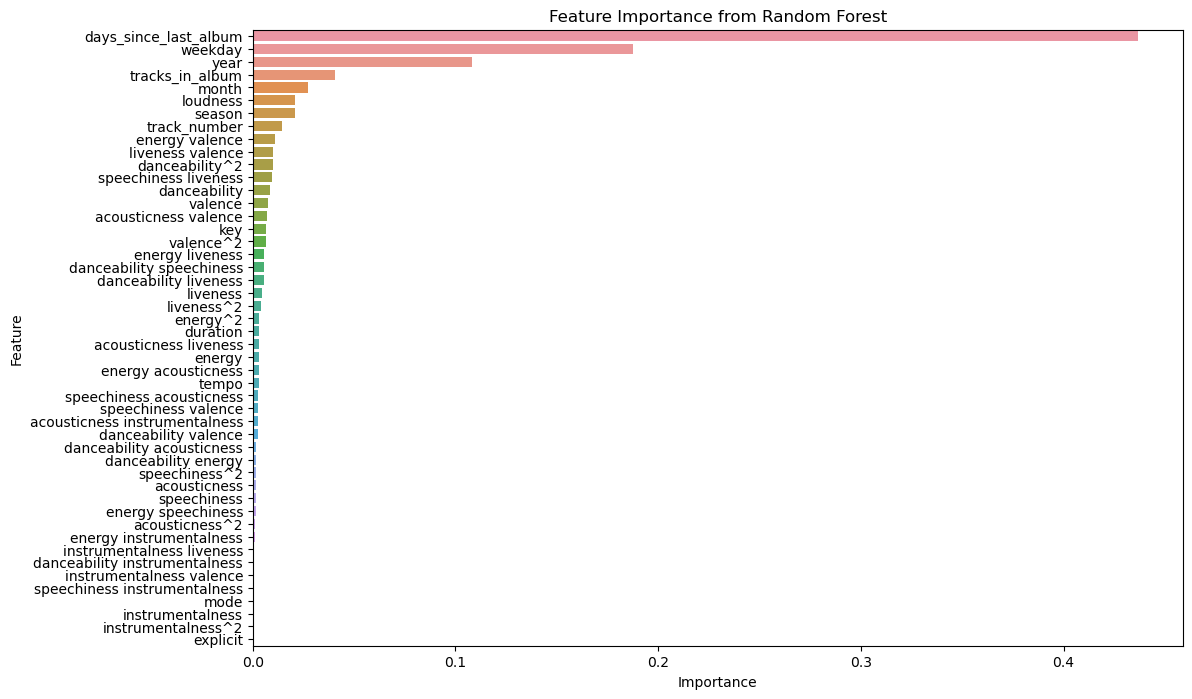

In [21]:
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=seed)
# Train the model
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the feature importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

In [22]:
# Define the number of top features to select
top_n =20

# Select the top_n features based on feature importance
top_features = feature_importance_df.nlargest(top_n, 'Importance')['Feature']

print(f"Top {top_n} features:")
print(top_features)

# Update the features to include only the selected top features
X_selected = X[top_features]

# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scale the selected features
scaler = StandardScaler()
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

Top 20 features:
18       days_since_last_album
16                     weekday
17                        year
19             tracks_in_album
15                       month
6                     loudness
14                      season
1                 track_number
32              energy valence
46            liveness valence
20              danceability^2
36        speechiness liveness
3                 danceability
12                     valence
41        acousticness valence
5                          key
47                   valence^2
31             energy liveness
22    danceability speechiness
25       danceability liveness
Name: Feature, dtype: object


In [23]:
# Initialize models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=n_estimators, random_state=seed),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=n_estimators, random_state=seed),
    'XGBoost': XGBRegressor(n_estimators=n_estimators, random_state=seed),
    'SupportVector': SVR(C=1.0, epsilon=0.2),
    'LinearRegression': LinearRegression(),
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_selected_scaled, y_train)
    y_pred = model.predict(X_test_selected_scaled)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} Mean Squared Error: {mse}')

RandomForest Mean Squared Error: 28.650761999999997
GradientBoosting Mean Squared Error: 52.27132854353285
XGBoost Mean Squared Error: 28.757293327439402
SupportVector Mean Squared Error: 130.02015945706887
LinearRegression Mean Squared Error: 87.86582903753664


## Model Training

In [24]:
# Set up cross-validation
kf = KFold(n_splits=20, shuffle=True, random_state=seed)

# Initialize lists to store results
train_losses = []
test_losses = []
validation_losses = []
track_number_importances = []
season_importances = []

# Hyperparameters for XGBoost
XGB_params = {
    'n_estimators': 1000,        # Number of boosting rounds
    'learning_rate': 0.01,       # Learning rate (step size shrinkage)
    'max_depth': 6,              # Maximum depth of each tree
    'min_child_weight': 1,       # Minimum sum of instance weight needed in a child
    'subsample': 0.8,            # Fraction of samples used for fitting each tree
    'reg_alpha': 0.1,            # L1 regularization term on weights
    'reg_lambda': 1.0,           # L2 regularization term on weights
    'random_state': seed,        # Random seed for reproducibility
    'early_stopping_rounds': 10  # Number of rounds to trigger early stopping
}

In [ ]:
# Loop over each train-test split
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nIteration {i+1}/{kf.get_n_splits()}")
    X_train_val, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_val, y_test = y.iloc[train_index], y.iloc[test_index]


    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform the training, validation, and test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Fit a RandomForestRegressor to get feature importances
    rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf.fit(X_train_scaled, y_train)

    # Get feature importances
    importances = rf.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Sort the feature importances in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Track the importance of 'track_number' and 'season'
    track_number_importance = feature_importance_df[feature_importance_df['Feature'] == 'track_number']['Importance'].values[0]
    season_importance = feature_importance_df[feature_importance_df['Feature'] == 'season']['Importance'].values[0]
    track_number_importances.append(track_number_importance)
    season_importances.append(season_importance)

    # Define the number of top features to select
    top_n = 20

    # Select the top_n features based on feature importance
    top_features = feature_importance_df.nlargest(top_n, 'Importance')['Feature']

    # Update the features to include only the selected top features
    X_train_selected = X_train[top_features]
    X_val_selected = X_val[top_features]
    X_test_selected = X_test[top_features]

    # Scale the selected features
    X_train_selected_scaled = scaler.fit_transform(X_train_selected)
    X_val_selected_scaled = scaler.transform(X_val_selected)
    X_test_selected_scaled = scaler.transform(X_test_selected)

    # Initialize the Gradient Boosting model with early stopping
    xgb_model = XGBRegressor(**XGB_params)

    # Fit the model and manually track validation loss
    xgb_model.fit(X_train_selected_scaled, y_train,
                  eval_set=[(X_val_selected_scaled, y_val)],
                  verbose=False)

    y_train_pred = xgb_model.predict(X_train_selected_scaled)
    y_val_pred = xgb_model.predict(X_val_selected_scaled)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_losses.append(train_rmse)
    validation_losses.append(val_rmse)

    # Evaluate on the test set
    y_test_pred = xgb_model.predict(X_test_selected_scaled)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_losses.append(test_rmse)

    print(f'Iteration {i+1} - XGBoost Train Root Mean Squared Error: {train_rmse}')
    print(f'Iteration {i+1} - XGBoost Validation Root Mean Squared Error: {val_rmse}')
    print(f'Iteration {i+1} - XGBoost Test Root Mean Squared Error: {test_rmse}')


Iteration 1/20
Iteration 1 - XGBoost Train Root Mean Squared Error: 2.2988245177061026
Iteration 1 - XGBoost Validation Root Mean Squared Error: 7.938218199494874
Iteration 1 - XGBoost Test Root Mean Squared Error: 5.585036572509562

Iteration 2/20
Iteration 2 - XGBoost Train Root Mean Squared Error: 1.146513668201373
Iteration 2 - XGBoost Validation Root Mean Squared Error: 6.443544339537908
Iteration 2 - XGBoost Test Root Mean Squared Error: 4.030135643418066

Iteration 3/20
Iteration 3 - XGBoost Train Root Mean Squared Error: 0.8248645910773733
Iteration 3 - XGBoost Validation Root Mean Squared Error: 4.449351865535617
Iteration 3 - XGBoost Test Root Mean Squared Error: 3.9762932282569183

Iteration 4/20
Iteration 4 - XGBoost Train Root Mean Squared Error: 1.1365406346192264
Iteration 4 - XGBoost Validation Root Mean Squared Error: 3.8829087546523673
Iteration 4 - XGBoost Test Root Mean Squared Error: 4.442979959925607

Iteration 5/20
Iteration 5 - XGBoost Train Root Mean Squared E

In [ ]:
# Print average performance metrics
print(f'\nAverage Validation Mean Squared Error: {np.mean(validation_losses)}')
print(f'Average Test Mean Squared Error: {np.mean(test_losses)}')

# Plot histograms for the MSEs
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
sns.histplot(validation_losses, bins=10, kde=True)
plt.xlabel('Validation MSE')
plt.ylabel('Frequency')
plt.title('Histogram of Validation MSE across K-Fold Splits')

plt.subplot(1, 2, 2)
sns.histplot(test_losses, bins=10, kde=True)
plt.xlabel('Test MSE')
plt.ylabel('Frequency')
plt.title('Histogram of Test MSE across K-Fold Splits')

plt.tight_layout()
plt.show()

In [ ]:
# Plot the feature importances for 'track_number' and 'season'
plt.figure(figsize=(12, 8))
sns.boxplot(data=[track_number_importances, season_importances], palette="Set2")
plt.xticks([0, 1], ['Track Number', 'Season'])
plt.ylabel('Importance')
plt.title('Feature Importances for Track Number and Season Across K-Fold Splits')
plt.show()

## Model Testing on Another Artist 

In [ ]:
#Let's try on Shawn Mendes
spotify_songs['track_album_release_date'] = pd.to_datetime(spotify_songs['track_album_release_date'], errors='coerce')

# Extract Taylor Swift songs from the Spotify dataset
spotify_shawn_songs = spotify_songs[spotify_songs['track_artist'].str.contains('Shawn Mendes', case=False, na=False)]

In [ ]:
# Renaming Cols to match the original Dataframes
spotify_shawn_songs = spotify_shawn_songs.rename(columns={
    'track_popularity': 'popularity',
    'track_album_release_date': 'release_date',
    'track_album_name': 'album_name_x'
})

In [ ]:
print("Spotify Shawn Mendes Songs Dataset:")
spotify_shawn_songs.head()

In [ ]:
# Check for missing values and data types
print("\nSpotify Shawn Mendes Songs Info:")
spotify_shawn_songs.info()

In [ ]:
spotify_shawn_songs.describe()

In [ ]:
X, y = preprocessData(spotify_shawn_songs, target)

In [ ]:
print(f'The shape of features: {X.shape}')
print(f'The shape of y: {y.shape}')